# **ORB Feature Matcher**

This notebook walks you through how ORB works and how it's used to filter out unrelated input images before building a 3D mesh.

---

### 🔍 What is ORB?

- ORB (Oriented FAST and Rotated BRIEF) is a lightweight, real-time feature detection method. It’s optimized for speed and low memory usage—perfect for fast image filtering.  
- Bonus: it’s open-source and free from licensing restrictions (unlike SIFT or SURF).


### 🤔 Why Do We Need ORB?

- When uploading input images, it’s easy to accidentally include an unrelated one (say, a photo of your cat). That could break your mesh reconstruction.
- ORB compares key visual features and filters out mismatches—so your model only sees what matters.


### ⚙️ How Does ORB Work?

- Even if your images have different angles, lighting, or devices, ORB can detect shared patterns across them.
- It uses FAST to find keypoints, Harris scoring to rank them, and BRIEF (with rotation invariance) to describe them.
- That way, ORB preserves the real-world structure and ignores the visual noise.

**P.S.** If you want to dive deeper into how ORB compares to SIFT and SURF? Check out this article [A Comparison of SIFT, SURF, and ORB on OpenCV](https://mikhail-kennerley.medium.com/a-comparison-of-sift-surf-and-orb-on-opencv-59119b9ec3d0)

---

### 🧪 Time to Put It to the Test!

We’re going to explore how ORB works step by step, and then implement our own `orb_matcher` to filter the images. Here’s the plan:

1. Check the images  
2. Detect keypoints using FAST  
3. Rank keypoints with Harris score  
4. Compute descriptors using ORB (Rotated BRIEF)  
5. Match keypoints between images

---

## **1. Check the images**

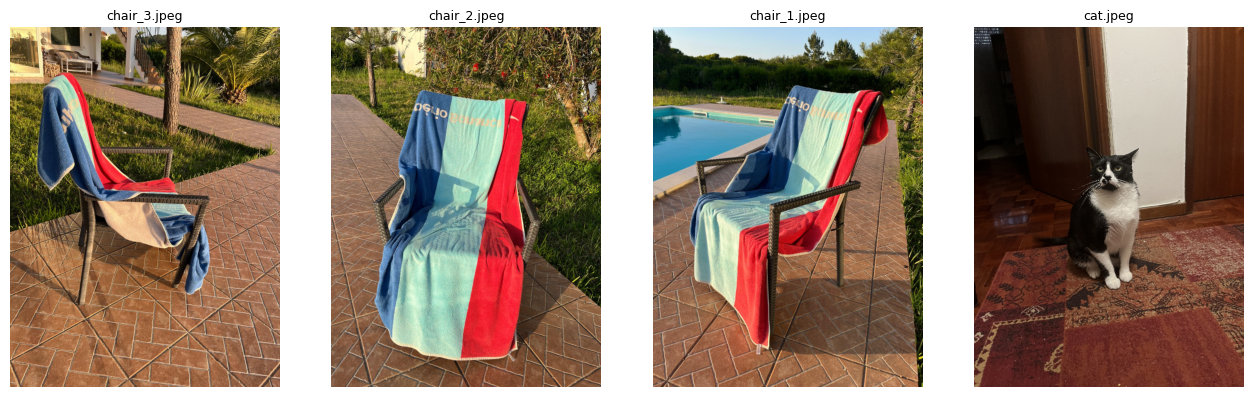

In [ ]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Path to the images
image_dir = '../test_images'
image_files = sorted(
    [f for f in os.listdir(image_dir) if f.endswith('.jpeg')],
    reverse=True
)

# Read the images
img_dict = {}
for img_name in image_files:
    path = os.path.join(image_dir, img_name)
    img = cv.imread(path, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (600, 800)) # Resize to avoid long computation time
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB for matplotlib
    img_dict[img_name] = img_rgb # Associate filename with respective image

# Plot
fig, axs = plt.subplots(1, len(img_dict), figsize=(13, 4))
for ax, (img_name, img) in zip(axs, img_dict.items()):
    ax.imshow(img)
    ax.set_title(img_name, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

> I’ve got 3 images of a chair with a towel that I want to mesh for my game. But while feeding them into the program, **I accidentally tossed in a photo of my cat... Let’s see how ORB reacts.**

## **2. Detect Keypoints using FAST**

### What is FAST?

Before ORB can compare images, it needs to find the keypoints, distinctive spots in each image, like corners or textured regions.

To do that quickly, it uses **FAST (Features from Accelerated Segment Test)**, a super fast algorithm designed for real-time detection with minimal computation. It gives us a rough but efficient set of feature candidates to work with.

Here's how it works:

- It checks a circle of pixels around each one in the image.
- If a certain number of those pixels are much brighter or darker than the center, it marks it as a keypoint.
- It skips boring, flat areas and finds areas with contrast, which are useful for matching later.

### Why FAST?

- **Speed**: It’s designed to be *fast*, making it great for real-time use.
- **Efficiency**: It quickly gives us lots of potential features to work with.

### Any downsides?

FAST keypoints are just points (x, y) — they don’t have **orientation** or **scale** info.  
This means they can break under rotation or zoom.

But don’t worry, we’ll fix that in the next steps using ORB!

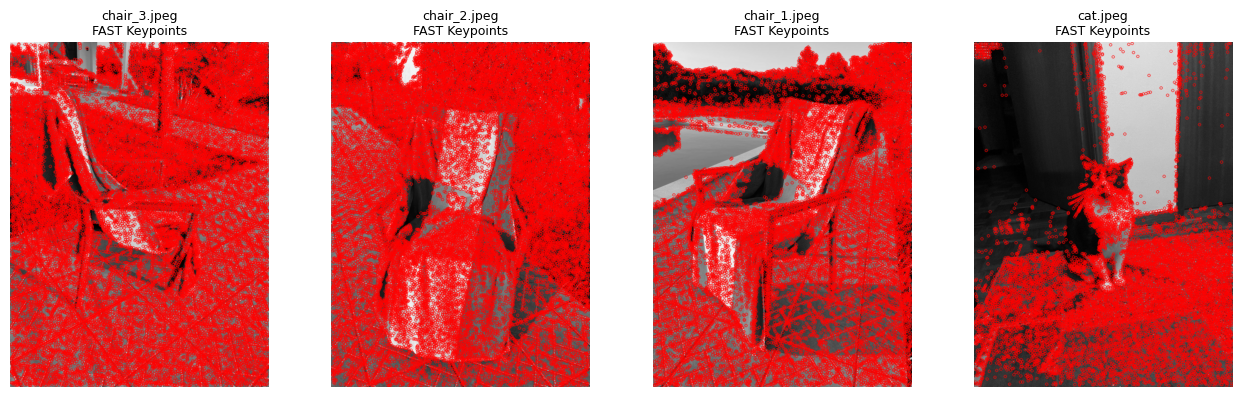

In [ ]:
# Convert RGB images to grayscale for FAST keypoint detection
gray_img_dict = {img_name: cv.cvtColor(img, cv.COLOR_RGB2GRAY) for img_name, img in img_dict.items()}

# Initialize FAST detector instance
fast = cv.FastFeatureDetector_create()

# Detect keypoints for each image & draw them on the images
keypoints_dict = {}
img_dict_kp = {}
for img_name, gray_img in gray_img_dict.items():
    kp = fast.detect(gray_img, None) # Detect keypoints
    keypoints_dict[img_name] = kp

    img_kp = cv.drawKeypoints(gray_img, kp, None, color=(255, 0, 0)) # Draw keypoints on the image
    img_dict_kp[img_name] = img_kp

# Plot
fig, axs = plt.subplots(1, len(img_dict), figsize=(13, 4))
for ax, (img_name, img) in zip(axs, img_dict_kp.items()):
    ax.imshow(img)
    ax.set_title(f'{img_name}\nFAST Keypoints', fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## **3. Rank Keypoints using Harris Score**

Now that we've found a bunch of potential keypoints with FAST, it's time to figure out which ones are actually useful.

FAST is fast (as the name says), but it's not picky - **it may detect too many weak or unstable points as we can see in the chair pictures**. To refine our selection, we score each keypoint using the Harris corner measure, which tells us how corner-like a point is (strong corners = better features).

By ranking all the detected points with this score, we can keep only the top keypoints that are most likely to be stable and distinctive—ideal for matching across images.


### What is the Harris Score?


Now that we've found a bunch of potential keypoints with FAST, it's time to figure out which ones are actually useful. FAST is fast (as the name says), but it's not picky, **it may detect too many weak or unstable points as we can see in the chair pictures**. 

To refine our selection, we need a way to **rank** them, not all corners are equally useful. **Harris Score** helps us measure how "strong" or "distinctive" each keypoint is.

### How does it work?

- It looks at how much the image changes around a keypoint in different directions.
- Strong corners (like where two edges meet) give **high scores**.
- Flat areas or edges alone get **low scores**.

### Why rank?

FAST can give **too many** keypoints — some are noisy or weak.

By ranking all the detected points with this score, we can keep only the top keypoints that are most likely to be stable and distinctive ideal for matching multiple images.

### In short:

Harris Score says:  
> “Let’s sort these keypoints and keep only the strongest, most interesting ones.”

That way, we avoid wasting time matching weak or useless features!

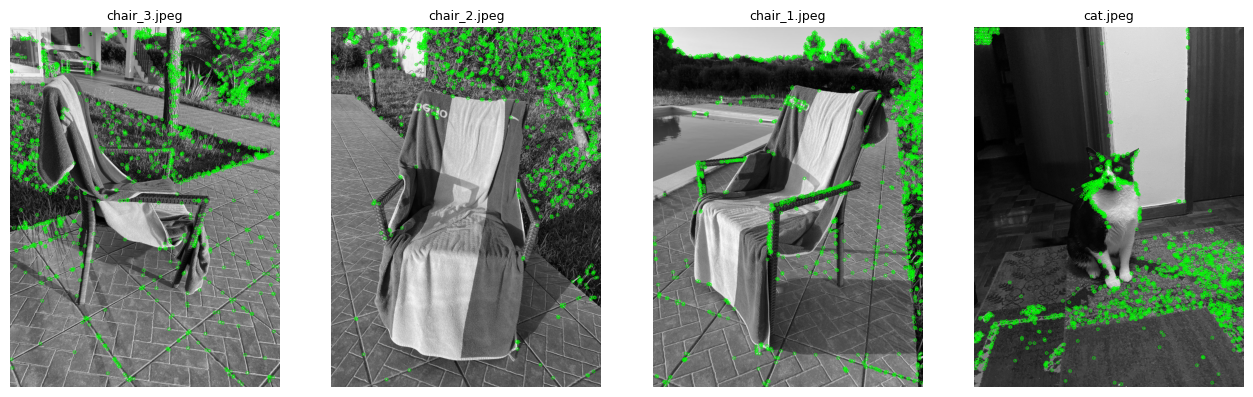

In [ ]:
def harris_rank_kp(
        img: np.array, keypoints: list[cv.KeyPoint], top_k: int = 100
) -> list[cv.KeyPoint]:
    """
    Evaluates keypoints importance by computing Harris corner strength
    for each and selects the top K most distinctive ones.
    
    Params:
        img (np.ndarray): Grayscale image.
        keypoints (list[cv.KeyPoint]): Keypoints detected by a feature detector (e.g. FAST).
        top_k (int): Number of top keypoints to return (default is 50).

    Returns: 
        list[cv.KeyPoint]: Top ranked keypoints based on Harris response.
    """
    # Convert image to float32 for corner Harris
    gray = np.float32(img)

    # Compute Harris corner response
    harris_response = cv.cornerHarris(gray, blockSize = 2, ksize = 3, k = 0.04)
    harris_response = cv.dilate(harris_response, None) # Dilate results for marking the corners (not important)

    # Normalize the Harris response map (optional but useful for visualization or debugging)
    harris_response = cv.normalize(harris_response, None, 0, 255, cv.NORM_MINMAX)

    # Get Harris score for each keypoint
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        if 0 <= y < harris_response.shape[0] and 0 <= x < harris_response.shape[1]:
            kp.response = harris_response[y, x]
        else:
            kp.response = 0  # Out of bounds safeguard

    # Sort by Harris response (descending) and return top K keypoints
    keypoints_sorted = sorted(keypoints, key = lambda x: x.response, reverse=True)

    return keypoints_sorted[:top_k]

# Rank and draw top 1000 keypoints for each image
top_k = 1_500
top_kp_dict = {}
for img_name, gray_img in gray_img_dict.items():
    kp = keypoints_dict[img_name]
    top_kp = harris_rank_kp(gray_img, kp, top_k) # Rank keypoints

    top_kp_img = cv.drawKeypoints(gray_img, top_kp, None, color=(0, 255, 0)) # Draw top keypoints on the image
    top_kp_dict[img_name] = top_kp_img

# Plot
fig, axs = plt.subplots(1, len(img_dict), figsize=(13, 4))
for ax, (img_name, img) in zip(axs, top_kp_dict.items()):
    ax.imshow(img)
    ax.set_title(img_name, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## **3. Orient the Keypoints**

So far, we've used **FAST** to quickly detect points of interest (called **keypoints**) in each image. Then we used **Harris Corner Score** to pick the strongest ones.

But here's the thing:

> Those keypoints are just **x, y positions** — they don't know which way they're "facing".

That's a problem when we're comparing images that might be rotated.  
For example, two photos of the same object:

- One taken normally
- Another tilted 90°

Without orientation, those points won't line up — even if they're the same spot in the real world.

That's where ORB steps in again, giving each keypoint a **direction** based on its surrounding pixels, like telling it,  
> "Hey, remember which way you're pointing!"

This makes our matching **rotation invariant**, so even if the image is flipped or turned, we can still recognize the same features.

Let’s add orientation to our keypoints!

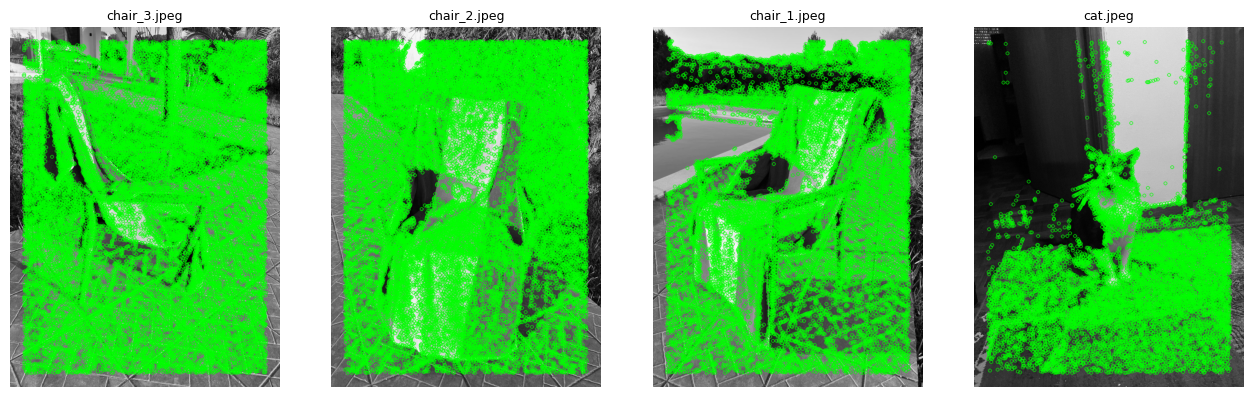

In [30]:
# Initialize ORB instance
orb = cv.ORB_create()

# Compute orientation for each image's keypoints & draw them with orientation arrows
img_oriented_kp_dict = {}
for img_name, gray_img in gray_img_dict.items():
    kp = keypoints_dict[img_name]
    orientated_kp = orb.compute(gray_img, kp)[0] # Compute orientation

    img_kp_oriented = cv.drawKeypoints(gray_img, orientated_kp, None, color=(0, 255, 0), flags=cv.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    img_oriented_kp_dict[img_name] = img_kp_oriented

# Plot
fig, axs = plt.subplots(1, len(img_dict), figsize=(13, 4))
for ax, (img_name, img) in zip(axs, img_oriented_kp_dict.items()):
    ax.imshow(img)
    ax.set_title(img_name, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## **4. Describe Keypoints with Rotated BRIEF (ORB)**

### What is BRIEF?

**BRIEF** stands for *Binary Robust Independent Elementary Features*.

It creates a compact **binary string** (like `101001...`) to describe what's around a keypoint, sort of like a fingerprint.

Here’s how it works:

- It picks random pairs of pixels in a small patch around the keypoint.
- If one pixel is brighter than the other, it writes a `1`, otherwise a `0`.
- After doing this many times, you get a unique string of 0s and 1s, **a descriptor**.

**This is fast, simple, and great for comparing features. But BRIEF has a problem, it’s not rotation invariant**.
That means if an object is upright in one image and rotated in another, BRIEF might describe the same keypoint *very differently*.  
This makes matching unreliable when images are taken at different angles.

### ORB Fixes That by Rotating the Patch

ORB improves BRIEF by aligning the patch **based on the keypoint's orientation** (which we calculated earlier).

Here's the idea:

> 🧭 "Let me rotate the image patch around the keypoint so it always faces the same direction, **then** I’ll apply BRIEF."

This rotation step makes the descriptors **rotation invariant**!  
So now, even if the same object appears tilted, flipped, or spun, ORB still gives similar descriptors.

### In Short:

> "Let me figure out which way this keypoint is pointing...  
> Now I'll rotate the area around it...  
> Then I'll describe it."

Thanks to this trick, ORB can match features across rotated images with much higher accuracy.

In [ ]:
# Use ORB's compute() to compute Rotated BRIEF descriptors


descriptors1 = orb.compute(img1, keypoints1)[1]
descriptors2 = orb.compute(img2, keypoints2)[1]

img1_with_desc = cv2.drawKeypoints(img1, keypoints1, None, color=(0, 255, 0), flags=0)
img2_with_desc = cv2.drawKeypoints(img2, keypoints2, None, color=(0, 255, 0), flags=0)

# Compute rotated BRIEF descriptors for each image's keypoints & draw them
img_descripted_dict = {}
for img_name, gray_img in gray_img_dict.items():
    kp = keypoints_dict[img_name]
    descriptors = orb.compute(gray_img, kp)[1] # Compute rotated BRIEF descriptors

    img_kp_oriented = cv.drawKeypoints(gray_img, descriptors, None, color=(0, 255, 0), flags=0)
    img_oriented_kp_dict[img_name] = img_kp_oriented

# Plot
fig, axs = plt.subplots(1, len(img_dict), figsize=(13, 4))
for ax, (img_name, img) in zip(axs, img_oriented_kp_dict.items()):
    ax.imshow(img)
    ax.set_title(img_name, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## **5. Match keypoints between images**

Now that we have descriptors for each keypoint, we can **match** them across images.

We do this using **Hamming distance**, which tells us how similar two binary strings are.

### What is Hamming Distance?

Hamming distance is a way to compare two binary strings, simply counting how many bits are different between them.

> For example:
>
> `101010` vs `100110` <br>
> Since 2 bits are different, it means Hamming distance = 2


This step helps us group related images and filter out the odd ones (like my cat photo 🐱).

## **6. Test our `orb_matcher` filtering logic**